In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['VOL_1857_1.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_3.xls',
                  'AICS-31_CD34+_Vol_(2).xls',
                  'Day10CD34V.xls', 
                  'VOL_CD34_other.xls',]

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['DOTS_1857_1.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_3.xls',
                'AICS-31_CD34+_Dots_(2).xls',
                'Day10CD34D.xls',
                'DOTS_CD34_other.xls',]

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 55481 / 26533
[Open3D DEBUG] #   Got kernel density: 0.00412703 (s), 459.836 (MB) / 459.836 (MB) / 459 (MB)
[Open3D DEBUG] #     Got normal field: 0.0436001 (s), 463.215 (MB) / 463.215 (MB) / 463 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 5.663308e-07 / 3.142060e-02
[Open3D DEBUG] #       Finalized tree: 0.0402160 (s), 466.008 (MB) / 466.008 (MB) / 466 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0460880 (s), 466.672 (MB) / 466.672 (MB) / 466 (MB)
[Open3D DEBUG] #Set point constraints: 0.00630903 (s), 467.777 (MB) / 467.777 (MB) / 467 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 226934 / 257392 / 1961
[Open3D DEBUG] Memory Usage: 467.777 MB
[Open3D DEBUG] # Linear system solved: 0.189892 (s), 475.586 (MB) / 475.586 (MB) / 475 (MB)
[Open3D DEBUG] Got average: 0.00534582 (s), 476.066 (MB) / 476.066 (MB) / 476 (MB)
[Open3D DEBUG] Iso-Value: 5.126396e-01 = 2.844176e+04 / 5.548100e+04
[Open3D DEBUG] #          Total Solve:     

[Open3D DEBUG] # Linear system solved: 0.214439 (s), 389.035 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] Got average: 0.00440884 (s), 389.082 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] Iso-Value: 5.112439e-01 = 2.324677e+04 / 4.547100e+04
[Open3D DEBUG] #          Total Solve:       1.4 (s),     515.0 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 977 / 858
[Open3D DEBUG] #   Got kernel density: 0.00112700 (s), 400.934 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] #     Got normal field: 0.00386405 (s), 400.934 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.778434e-05 / 1.737530e-02
[Open3D DEBUG] #       Finalized tree: 0.0137939 (s), 401.137 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.032481 (s), 401.148 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DEBUG] #Set point constraints: 0.00171995 (s), 401.148 (MB) / 514.965 (MB) / 523 (MB)
[Open3D DE

[Open3D DEBUG] Input Points / Samples: 12281 / 7767
[Open3D DEBUG] #   Got kernel density: 0.00195503 (s), 537.371 (MB) / 537.371 (MB) / 537 (MB)
[Open3D DEBUG] #     Got normal field: 0.0191238 (s), 537.371 (MB) / 537.371 (MB) / 537 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.245672e-06 / 1.529810e-02
[Open3D DEBUG] #       Finalized tree: 0.0293701 (s), 537.371 (MB) / 537.371 (MB) / 537 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.081126 (s), 537.371 (MB) / 537.371 (MB) / 537 (MB)
[Open3D DEBUG] #Set point constraints: 0.00527811 (s), 537.371 (MB) / 537.371 (MB) / 537 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 142983 / 160784 / 2625
[Open3D DEBUG] Memory Usage: 537.371 MB
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(386.266 MB)	Nodes: 8
CG: 1.1380e-02 -> 1.1380e-02 -> 2.9499e-07 (2.6e-05) [32680]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(386.266 MB)	Nodes

        GS: 1.3642e-01 -> 1.3642e-01 -> 1.7619e-03 (1.3e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.014 /  0.072	(523.125 MB)	Nodes: 35937
          GS: 1.0704e-01 -> 1.0704e-01 -> 1.5176e-03 (1.4e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.002	(523.125 MB)	Nodes: 2248
            GS: 1.0833e-01 -> 1.0833e-01 -> 4.2776e-04 (3.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(523.125 MB)	Nodes: 3472
              GS: 7.5278e-02 -> 7.5278e-02 -> 4.2799e-04 (5.7e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.016	(523.125 MB)	Nodes: 5608
                GS: 4.4872e-02 -> 4.4872e-02 -> 2.3032e-04 (5.1e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.004 /  0.005	(523.129 MB)	Nodes: 4496
                  GS: 4.0206e-02 -> 4.0206e-02 -> 5.0453e-0

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

B)	Nodes: 4913
        GS: 1.5836e-01 -> 1.5836e-01 -> 2.0967e-03 (1.3e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.019 /  0.089	(519.852 MB)	Nodes: 35937
          GS: 1.6498e-01 -> 1.6498e-01 -> 1.4503e-03 (8.8e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(519.852 MB)	Nodes: 2776
            GS: 1.7649e-01 -> 1.7649e-01 -> 8.2050e-04 (4.6e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(519.852 MB)	Nodes: 4184
              GS: 1.4291e-01 -> 1.4291e-01 -> 6.3319e-04 (4.4e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.004 /  0.024	(519.852 MB)	Nodes: 9280
                GS: 9.2083e-02 -> 9.2083e-02 -> 3.4827e-04 (3.8e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.005 /  0.034	(519.852 MB)	Nodes: 14408
                  GS: 4.4709e-02 -> 4.4709e

,Entity,Distance to Surface (μm)
0,A,1.579277
1,A,0.306275
2,A,2.315311
3,A,20.469770
4,A,2.665250
...,...,...
10741,F,NaN
10742,F,NaN
10743,F,NaN
10744,F,NaN


In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'

df['Entity'] = df['Entity'].replace({'A':'PDX',
              'B':'PDX',
              'C':'PDX',
              'D':'HSC',
              'E':'HSC',
              'F':'HSC'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

lved in:  0.001 /  0.005 /  0.003	(526.148 MB)	Nodes: 4913
        GS: 6.2604e-02 -> 6.2604e-02 -> 1.2718e-04 (2.0e-03) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.016 /  0.087	(526.148 MB)	Nodes: 35937
          GS: 7.4352e-02 -> 7.4352e-02 -> 2.0265e-04 (2.7e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.001	(526.152 MB)	Nodes: 1288
            GS: 6.1911e-02 -> 6.1911e-02 -> 1.7092e-04 (2.8e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(526.156 MB)	Nodes: 1536
              GS: 3.7593e-02 -> 3.7593e-02 -> 9.5551e-05 (2.5e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(526.156 MB)	Nodes: 1456
                GS: 2.7752e-02 -> 2.7752e-02 -> 4.9592e-05 (1.8e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.006 /  0.002 /  0.003	(526.168 MB)	Nodes: 560
 

,Entity,Distance to Surface (μm),Types
0,PDX,1.579277,Repeat 1
1,PDX,0.306275,Repeat 1
2,PDX,2.315311,Repeat 1
3,PDX,20.469770,Repeat 1
4,PDX,2.665250,Repeat 1
...,...,...,...
9077,HSC,156.765015,Repeat 3
9078,HSC,167.463226,Repeat 3
9079,HSC,227.550812,Repeat 3
9080,HSC,153.320679,Repeat 3


In [8]:
#leukemia data
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'Healthy Replicate 1',
                   'E': 'Healthy Replicate 2',
                   'F': 'Healthy Replicate 3'}, inplace=True)

#df.to_excel("unmelted_leukemia_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
#df_leukemia.to_excel("melted_leukemia_data.xlsx", sheet_name='meltedLEUK') 


/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_1050/892927422.py:10: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


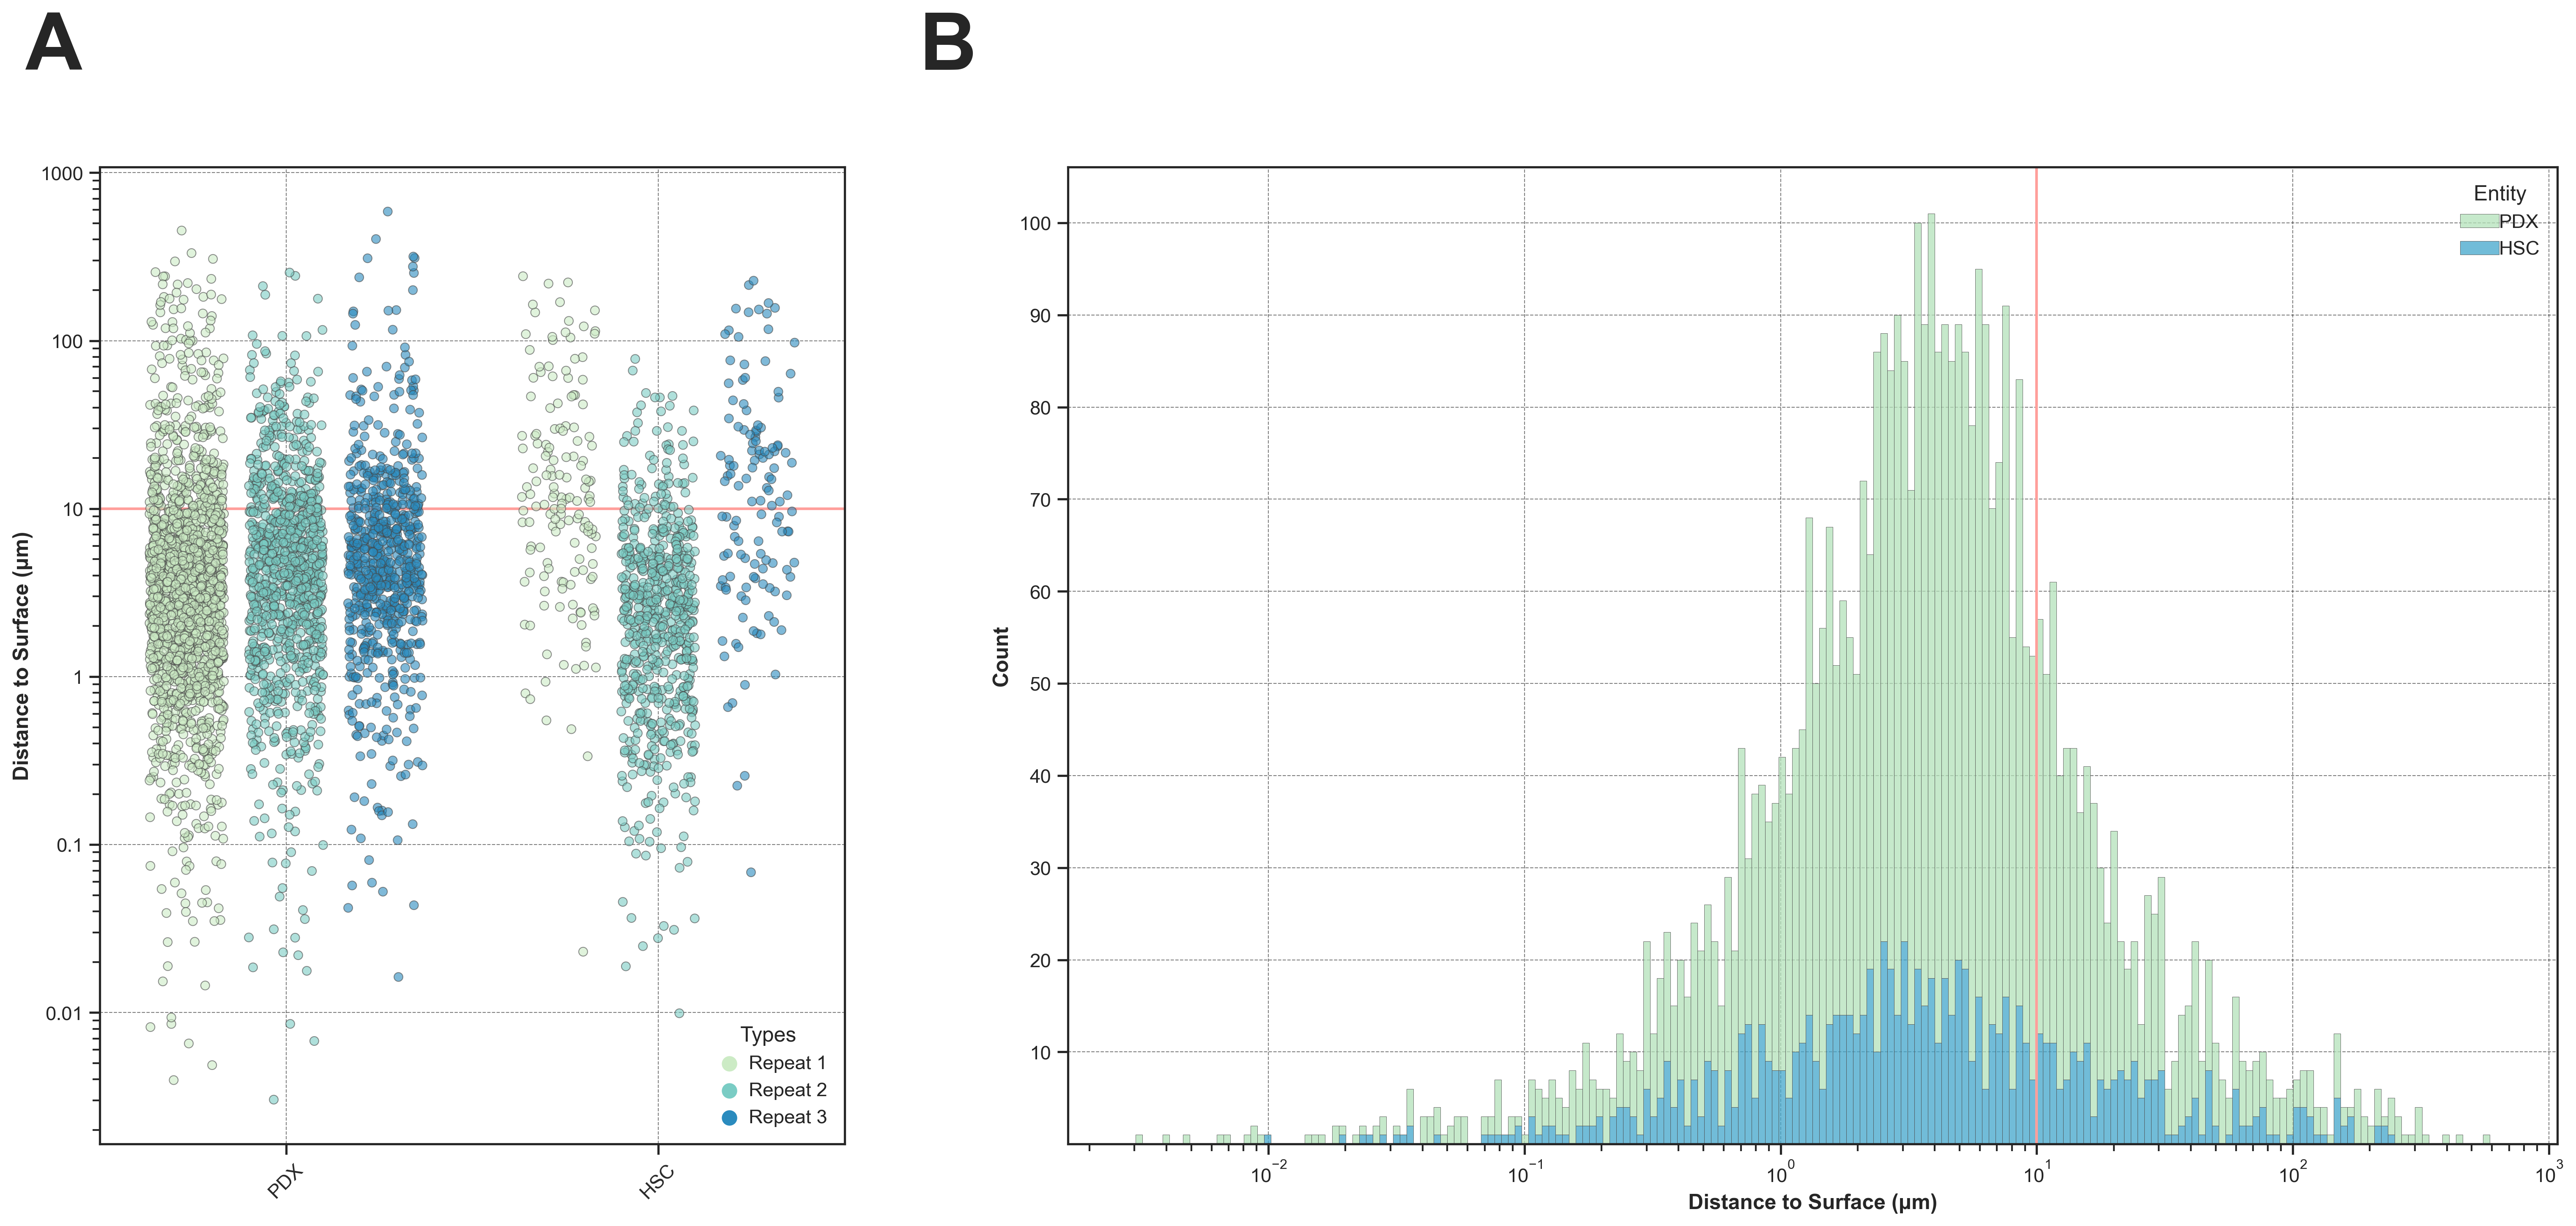

In [11]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')


texts = ['A', 'B']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('Seaborn_1857_v Healthy.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('Seaborn_1857_v Healthy.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()